In [ ]:
#default_exp vision.augment

# Data augmentation in computer vision

> Transforms that have different behavior for different parts of their input

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

In [ ]:
#hide
torch.cuda.set_device(int(os.environ.get('DEFAULT_GPU') or 0))

## Transforms

In [ ]:
PILImage.kwargs['cmap'] = 'Greys'

In [ ]:
path = untar_data(URLs.MNIST_TINY)
fns = get_image_files(path)
fn = fns[0]; fn
tmask = Maskify(func=lambda fn: Image.fromarray((array(Image.open(fn)) >= 127).astype(np.uint8)))
pnts = np.array([[0,0], [14,5], [28,0], [0,28], [14,28], [28,28]])
bboxes = (np.array([[0,0,7,7], [10,14,27, 27]]), ['tl', 'br'])

def _lbl(x):  return pnts
def _lbl1(x): return bboxes
tcat = BBoxCategorize(subset_idx=[0])

### General arch

In [ ]:
class RandTransform(Transform):
    "A transform that randomize its state at each `__call__`"
    def __init__(self, encodes=None, decodes=None, randomize=None, p=1.): 
        self.p = p
        if randomize is not None: self.randomize=randomize
        super().__init__(encodes, decodes)

    def randomize(self, b): self.do = random.random() < self.p
    def __call__(self, b, filt=None, **kwargs): 
        self.randomize(b) #Randomize before calling
        if not self.do: return b
        return super().__call__(b, filt=filt, **kwargs)

### PIL transforms

In [ ]:
def _minus_axis(x, axis):
    x[...,axis] = -x[...,axis]
    return x

class PILFlip(RandTransform):
    def __init__(self, p=0.5): self.p = p
    def encodes(self, x:PILImage):    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    def encodes(self, x:TensorPoint): return _minus_axis(x, 0)
    def encodes(self, x:TensorBBox):
        bb,lbl = x
        bb = _minus_axis(bb.view(-1,2), 0)
        return (bb.view(-1,4),lbl)

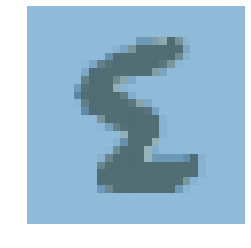

In [ ]:
tds = TfmdDS([fn], [[Imagify()], [tmask]], tuple_tfms=[PILFlip(), ImageToByteTensor()])
tds.show_at(0)

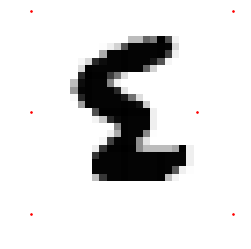

In [ ]:
tds = TfmdDS([fn], [[Imagify()], [_lbl,Pointify()]], tuple_tfms=[PointScaler(), PILFlip(), ImageToByteTensor()])
tds.show_at(0)

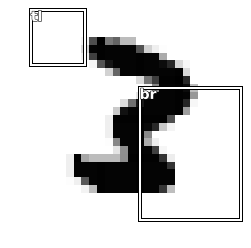

In [ ]:
tds = TfmdDS([fn], [[Imagify()], [_lbl1,BBoxify(), tcat]], tuple_tfms=[BBoxScaler(), PILFlip(), ImageToByteTensor()])
tds.show_at(0)

## Affine and coord tfm on the GPU

In [ ]:
# export
def clip_remove_empty(bbox, label):
    bbox = torch.clamp(bbox, -1, 1)
    empty = ((bbox[...,2] - bbox[...,0])*(bbox[...,3] - bbox[...,1]) < 0.)
    if isinstance(label, torch.Tensor): label[empty] = 0
    else:
        for i,m in enumerate(empty):
            if m: label[i] = 0
    return [bbox, label]

In [ ]:
class AffineCoordTfm(RandTransform):
    "Combine and apply random affine transforms"
    order = 30
    def __init__(self, aff_tfms=None, coord_tfms=None, size=None, mode='bilinear', pad_mode='reflection'):
        self.aff_tfms,self.coord_tfms,self.mode,self.pad_mode = L(aff_tfms),L(coord_tfms),mode,pad_mode
        self.size = None if size is None else (size,size) if isinstance(size, int) else tuple(size)
    
    def randomize(self, b): 
        self.do,self.mat = True,self._get_affine_mat(b[0])[:,:2]
        for t in self.coord_tfms: t.randomize(b[0])
        
    def compose(self, tfm):
        self.aff_tfms   += tfm.aff_tfms
        self.coord_tfms += tfm.coord_tfms
    
    def _get_affine_mat(self, x):
        aff_m = torch.eye(3, dtype=x.dtype, device=x.device)
        aff_m = aff_m.unsqueeze(0).expand(x.size(0), 3, 3)
        ms = [tfm(x) for tfm in self.aff_tfms]
        ms = [m for m in ms if m is not None]
        for m in ms: aff_m = aff_m @ m
        return aff_m
    
    def encodes(self, x:TensorImage):
        if self.mat is None and len(self.coord_tfms)==0: return x
        bs = x.size(0)
        size = tuple(x.shape[-2:]) if self.size is None else size
        size = (bs,x.size(1)) + size
        coords = F.affine_grid(self.mat, size)
        coords = compose_tfms(coords, self.coord_tfms)
        return F.grid_sample(x, coords, mode=self.mode, padding_mode=self.pad_mode)
    
    def encodes(self, x:TensorMask):
        return self._get_func(self.encodes, TensorImage)(x.float()[:,None]).long()[:,0]
    
    def encodes(self, x:TensorPoint):
        x = (x - self.mat[:,:,2].unsqueeze(1)) @ torch.inverse(self.mat[:,:,:2].transpose(1,2))
        return compose_tfms(x, self.coord_tfms, invert=True)
    
    def encodes(self, x:TensorBBox):
        bbox,label = x
        bs,n = bbox.shape[:2]
        pnts = stack([bbox[...,:2], stack([bbox[...,0],bbox[...,3]],dim=2), 
                      stack([bbox[...,2],bbox[...,1]],dim=2), bbox[...,2:]], dim=2)
        pnts = self._get_func(self.encodes, TensorPoint)(pnts.view(bs, 4*n, 2))
        pnts = pnts.view(bs, n, 4, 2)
        tl,dr = pnts.min(dim=2)[0],pnts.max(dim=2)[0]
        return clip_remove_empty(torch.cat([tl, dr], dim=2), label)

In [ ]:
# export
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli

def affine_mat(*ms):
    "Restructure length-9 vector `ms` into an affine matrix"
    return stack([stack([ms[0], ms[1], ms[2]], dim=1),
                  stack([ms[3], ms[4], ms[5]], dim=1),
                  stack([ms[6], ms[7], ms[8]], dim=1)], dim=1)

In [ ]:
def flip_affine(x, p=0.5):
    "Flip as an affine transform"
    mask = -2*x.new_empty(x.size(0)).bernoulli_(p)+1
    return affine_mat(mask,     t0(mask), t0(mask),
                      t0(mask), t1(mask), t0(mask),
                      t0(mask), t0(mask), t1(mask))

In [ ]:
# export
def mask_tensor(x, p=0.5, neutral=0.):
    if p==1.: return x
    if neutral != 0: x.add_(-neutral)
    mask = x.new_empty(*x.size()).bernoulli_(p)
    x.mul_(mask)
    return x.add_(neutral) if neutral != 0 else x

In [ ]:
# export
def masked_uniform(x, a, b, *sz, p=0.5, neutral=0.):
    return mask_tensor(x.new_empty(*sz).uniform_(a,b), p=p, neutral=neutral)

In [ ]:
# export
def rotate(x, max_deg=10, p=0.5):
    thetas = masked_uniform(x, -max_deg, max_deg, x.size(0), p=p) * math.pi/180
    return affine_mat(thetas.cos(), thetas.sin(), t0(thetas),
                     -thetas.sin(), thetas.cos(), t0(thetas),
                      t0(thetas),   t0(thetas),   t1(thetas))

In [ ]:
tds = TfmdDS([fn]*10, [[Imagify()], [tmask]], tuple_tfms=[ImageToByteTensor()])
tdl = TfmdDL(tds, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(flip_affine)], bs=9)

In [ ]:
tds = TfmdDS([fn]*10, [[Imagify()], [_lbl,Pointify()]], tuple_tfms=[PointScaler(), ImageToByteTensor()])
tdl = TfmdDL(tds, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(flip_affine)], bs=9)

In [ ]:
tds = TfmdDS([fn]*10, [[Imagify()], [_lbl1,BBoxify(), tcat]], tuple_tfms=[BBoxScaler(), ImageToByteTensor()])
tdl = TfmdDL(tds, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(partial(rotate, max_deg=30))], bs=9)

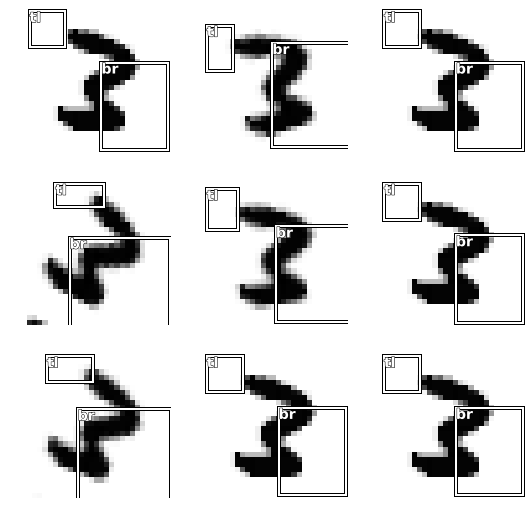

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
tdl.show_batch(ctxs=axs.flatten())

In [ ]:
def flip_dihedral(x, p=0.5): #TODO: check it works
    idx = mask_tensor(torch.randint(0, 8, (x.size(0),), device=x.device), p=p)
    xs = 1 - 2*(idx & 1)
    ys = 1 - (idx & 2)
    m0,m1 = (idx<4).long(),(idx>3).long()
    return affine_mat(xs*m0,  xs*m1,  t0(xs),
                      ys*m1,  ys*m0,  t0(xs),
                      t0(xs), t0(xs), t1(xs)).float()

### Warping

In [ ]:
# export
def find_coeffs(p1, p2):
    matrix = []
    p = p1[:,0,0]
    #The equations we'll need to solve.
    for i in range(p1.shape[1]):
        matrix.append(stack([p2[:,i,0], p2[:,i,1], t1(p), t0(p), t0(p), t0(p), -p1[:,i,0]*p2[:,i,0], -p1[:,i,0]*p2[:,i,1]]))
        matrix.append(stack([t0(p), t0(p), t0(p), p2[:,i,0], p2[:,i,1], t1(p), -p1[:,i,1]*p2[:,i,0], -p1[:,i,1]*p2[:,i,1]]))
    #The 8 scalars we seek are solution of AX = B
    A = stack(matrix).permute(2, 0, 1)
    B = p1.view(p1.shape[0], 8, 1)
    return torch.solve(B,A)[0]

In [ ]:
# export
def apply_perspective(coords, coeffs):
    sz = coords.shape
    coords = coords.view(sz[0], -1, 2)
    coeffs = torch.cat([coeffs, t1(coeffs[:,:1])], dim=1).view(coeffs.shape[0], 3,3)
    coords = coords @ coeffs[...,:2].transpose(1,2) + coeffs[...,2].unsqueeze(1)
    coords.div_(coords[...,2].unsqueeze(-1))
    return coords[...,:2].view(*sz)

In [ ]:
# export
class Warp():
    def __init__(self, magnitude=0.2, p=0.5):
        self.coeffs,self.magnitude,self.p = None,magnitude,p
    
    def randomize(self, x):
        up_t = masked_uniform(x, -self.magnitude, self.magnitude, x.size(0), p=self.p)
        lr_t = masked_uniform(x, -self.magnitude, self.magnitude, x.size(0), p=self.p)
        orig_pts = torch.tensor([[-1,-1], [-1,1], [1,-1], [1,1]], dtype=x.dtype, device=x.device)
        self.orig_pts = orig_pts.unsqueeze(0).expand(x.size(0),4,2)
        targ_pts = stack([stack([-1-up_t, -1-lr_t]), stack([-1+up_t, 1+lr_t]), 
                          stack([ 1+up_t, -1+lr_t]), stack([ 1-up_t, 1-lr_t])])
        self.targ_pts = targ_pts.permute(2,0,1)
    
    def __call__(self, x, invert=False): 
        coeffs = find_coeffs(self.targ_pts, self.orig_pts) if invert else find_coeffs(self.orig_pts, self.targ_pts)
        return apply_perspective(x, coeffs)

In [ ]:
tds = TfmdDS([fn]*10, [[Imagify()], [_lbl,Pointify()]], tuple_tfms=[PointScaler(), ImageToByteTensor()])
tdl = TfmdDL(tds, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(coord_tfms=Warp(0.4))], bs=9)

In [ ]:
tds = TfmdDS([fn]*10, [[Imagify()], [_lbl1,BBoxify(), tcat]], tuple_tfms=[BBoxScaler(), ImageToByteTensor()])
tdl = TfmdDL(tds, tfms=[Cuda(), ByteToFloatTensor(), AffineCoordTfm(coord_tfms=Warp())], bs=9)

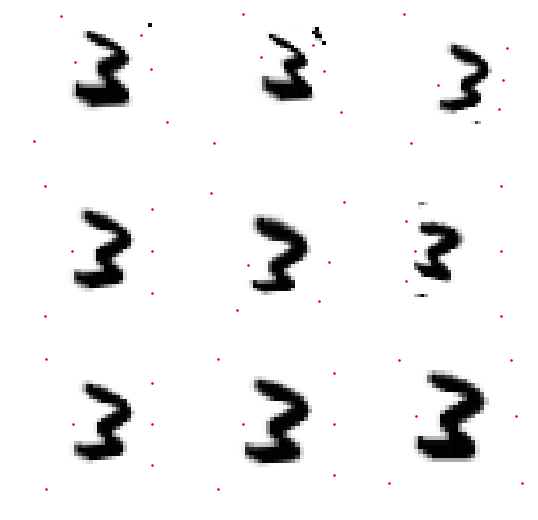

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
tdl.show_batch(ctxs=axs.flatten())